In [4]:
%load_ext watermark
%watermark -a "Romell D.Z." -u -d -p numpy,pandas,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Romell D.Z. 
last updated: 2019-01-20 

numpy 1.14.6
pandas 0.23.4
matplotlib 2.2.2
sklearn 0.20.0


# 3. Machine Learning Tuning

In [5]:
from __future__ import division
import warnings
warnings.simplefilter('ignore' )
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (18,6) 

In [6]:
dataset = pd.read_json('dataset.json',orient='split')
dataset.head()

,numeric,text,with_missing,label
0,-10.856306,,4.433240,b
1,9.973454,foo,4.310229,b
2,2.829785,foo bar,2.469828,a
3,-15.062947,,2.852981,b
4,-5.786003,foo bar,1.826475,a


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
numeric         1000 non-null float64
text            1000 non-null object
with_missing    822 non-null float64
label           1000 non-null object
dtypes: float64(2), object(2)
memory usage: 39.1+ KB


In [8]:
# Value empty in 'text column'
dataset[dataset['text']==''].shape[0]

210

In [9]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
numeric,1000.0,-0.395641,10.012883,-32.310550,-6.845566,-0.411856,6.688657,35.715792
with_missing,822.0,3.025194,0.994960,-0.801378,2.386520,3.022887,3.693381,5.850708


In [10]:
dataset['label'].head()

0    b
1    b
2    a
3    b
4    a
Name: label, dtype: object

In [11]:
pd.get_dummies(dataset['label']).head()

,a,b
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


In [12]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

X_train, X_test, y_train, y_test = train_test_split(dataset[['numeric']],
                                                    pd.get_dummies(dataset['label']))

pl = Pipeline([ ('model', OneVsRestClassifier(LogisticRegression())) ])

pl.fit(X_train, y_train)

accuracy = pl.score(X_test, y_test)
print("Accuracy on dataframe with Numerical & Label: ", accuracy)

Accuracy on dataframe with Numerical & Label:  0.688


In [13]:
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(dataset[['numeric', 'with_missing']],
                                                    pd.get_dummies(dataset['label']))

pl = Pipeline([
        ('imputer', Imputer()),
        ('model', OneVsRestClassifier(LogisticRegression()))
    ])

pl.fit(X_train,y_train)

# Compute and print accuracy
accuracy = pl.score(X_test,y_test)
print("Accuracy on dataframe with All Numerical: ", pl.score(X_test,y_test))

Accuracy on dataframe with All Numerical:  0.648


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(dataset['text'],
                                                    pd.get_dummies(dataset['label']))

pl = Pipeline([
        ('vec', CountVectorizer()),
        ('model', OneVsRestClassifier(LogisticRegression())) ])

pl.fit(X_train,y_train)
print("Accuracy on dataframe with only text data: ", pl.score(X_test,y_test))

Accuracy on dataframe with only text data:  0.848


In [15]:
from sklearn.preprocessing import FunctionTransformer

extract_text = FunctionTransformer(lambda x: x['text'], validate=False)
text_data = extract_text.fit_transform(dataset)

extract_numeric = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)
numeric_data = extract_numeric.fit_transform(dataset)

print('Extracting Text Data')
print(text_data.head())
print('Extracting Numeric Data')
print(numeric_data.head())

Extracting Text Data
0           
1        foo
2    foo bar
3           
4    foo bar
Name: text, dtype: object
Extracting Numeric Data
     numeric  with_missing
0 -10.856306      4.433240
1   9.973454      4.310229
2   2.829785      2.469828
3 -15.062947      2.852981
4  -5.786003      1.826475


In [16]:
from sklearn.pipeline import FeatureUnion

X_train, X_test, y_train, y_test = train_test_split(dataset[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(dataset['label']))

pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

pip.fit(X_train, y_train)
pred_prob_LR = pip.predict_proba(X_test)[:,0]

accuracy = pip.score(X_test, y_test)
print("Accuracy on all dataset: %.4f"% accuracy)

Accuracy on all dataset: 0.9280


In [17]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MaxAbsScaler
chi_k = 2 # 300
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()), 
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

pip.fit(X_train, y_train)
pred_prob_M_LR = pip.predict_proba(X_test)[:,0]

print("Accuracy on all dataset: %.4f"% pip.score(X_test, y_test))

Accuracy on all dataset: 0.7280


In [18]:
from sklearn.tree import DecisionTreeClassifier

pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', DecisionTreeClassifier())
    ])

pip.fit(X_train, y_train)
pred_prob_DT = pip.predict_proba(X_test)[0][:,1]

print("Accuracy on all dataset: %.4f"% pip.score(X_test, y_test)  )

Accuracy on all dataset: 0.8800


In [19]:
from sklearn.preprocessing import StandardScaler
pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer()),
                    ('scaler', StandardScaler())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', DecisionTreeClassifier())
    ])

pip.fit(X_train, y_train)
pred_prob_SS_DT = pip.predict_proba(X_test)[0][:,1]

print("Accuracy on all dataset: %.4f"% pip.score(X_test, y_test)  )

Accuracy on all dataset: 0.8840


In [20]:
from sklearn.ensemble import RandomForestClassifier

pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

pip.fit(X_train, y_train) 
pred_prob_RFC = pip.predict_proba(X_test)[0][:,1]
print("Accuracy on all dataset: %.4f"% pip.score(X_test, y_test)  )

Accuracy on all dataset: 0.8760


In [21]:
from sklearn.ensemble import RandomForestClassifier

pip = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', extract_numeric),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', extract_text),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

pip.fit(X_train, y_train)
pred_prob_RFC_15 = pip.predict_proba(X_test)[0][:,1]

print("Accuracy on all dataset: %.4f"% pip.score(X_test, y_test)  )

Accuracy on all dataset: 0.9040


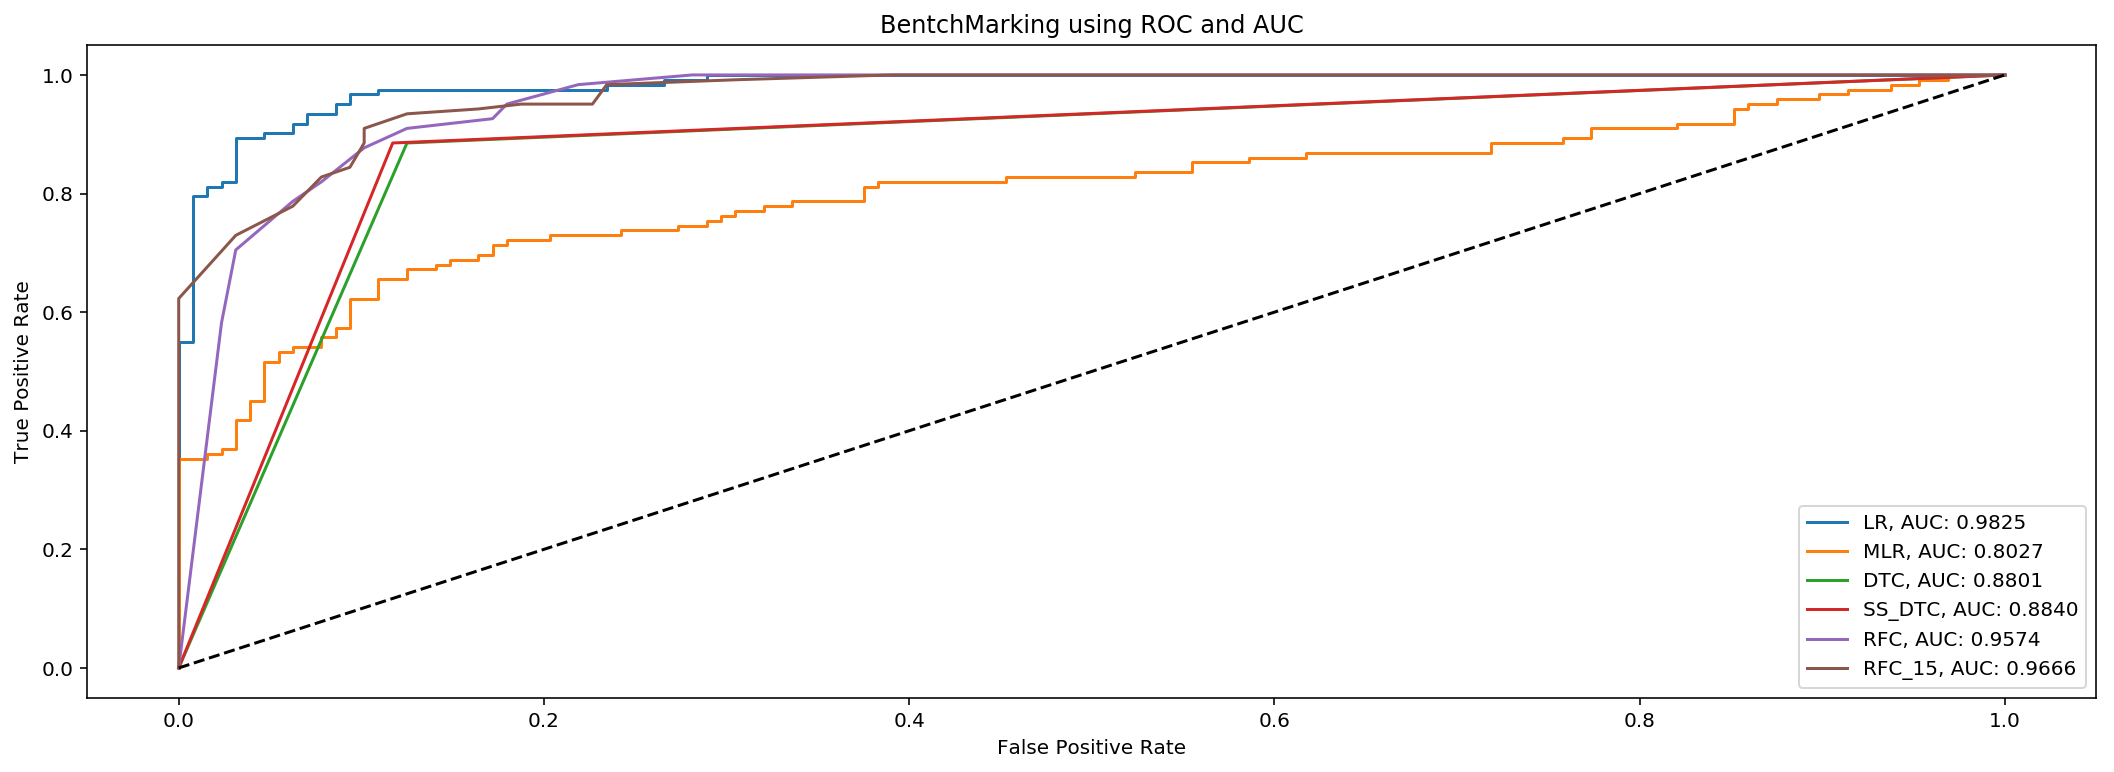

In [22]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
for label,y_pred_prob in zip(["LR","MLR","DTC","SS_DTC","RFC","RFC_15"],
                    [pred_prob_LR,pred_prob_M_LR,pred_prob_DT,pred_prob_SS_DT,pred_prob_RFC,pred_prob_RFC_15]):
    fpr,tpr, _ = roc_curve(y_test.iloc[:,0], y_pred_prob)
    plt.plot(fpr, tpr,label=label+str(", AUC: %.4f"%auc(fpr,tpr)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.title('BentchMarking using ROC and AUC')
plt.savefig('snapshot/roc_curve',bbox_inches='tight',dpi=100);

train_sizes: [ 80 131 182 234 285 337 388 440 491 542 594 645 697 748 800]


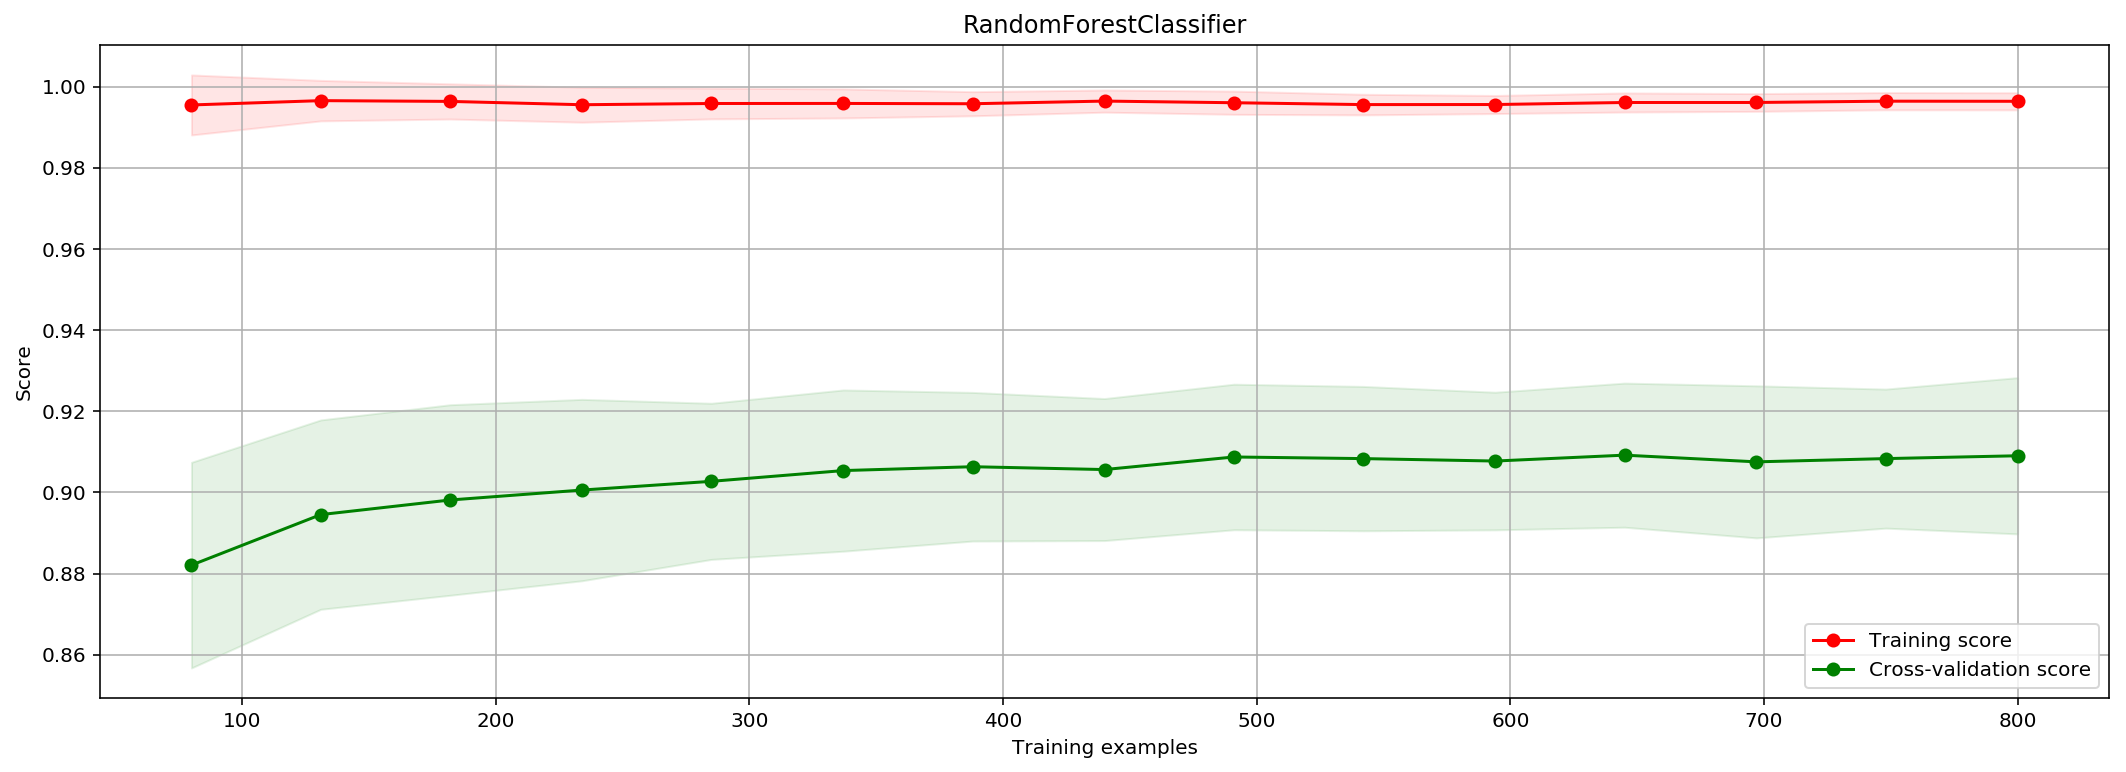

In [23]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
plt.figure()
plt.title("RandomForestClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes, train_scores, test_scores = learning_curve(
    pip, dataset[['numeric', 'with_missing', 'text']], pd.get_dummies(dataset['label']),
    cv=cv,train_sizes=np.linspace(.1, 1.0, 15))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
print('train_sizes:',train_sizes)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="lower right")
plt.savefig('snapshot/learning_curve',bbox_inches='tight',dpi=100);

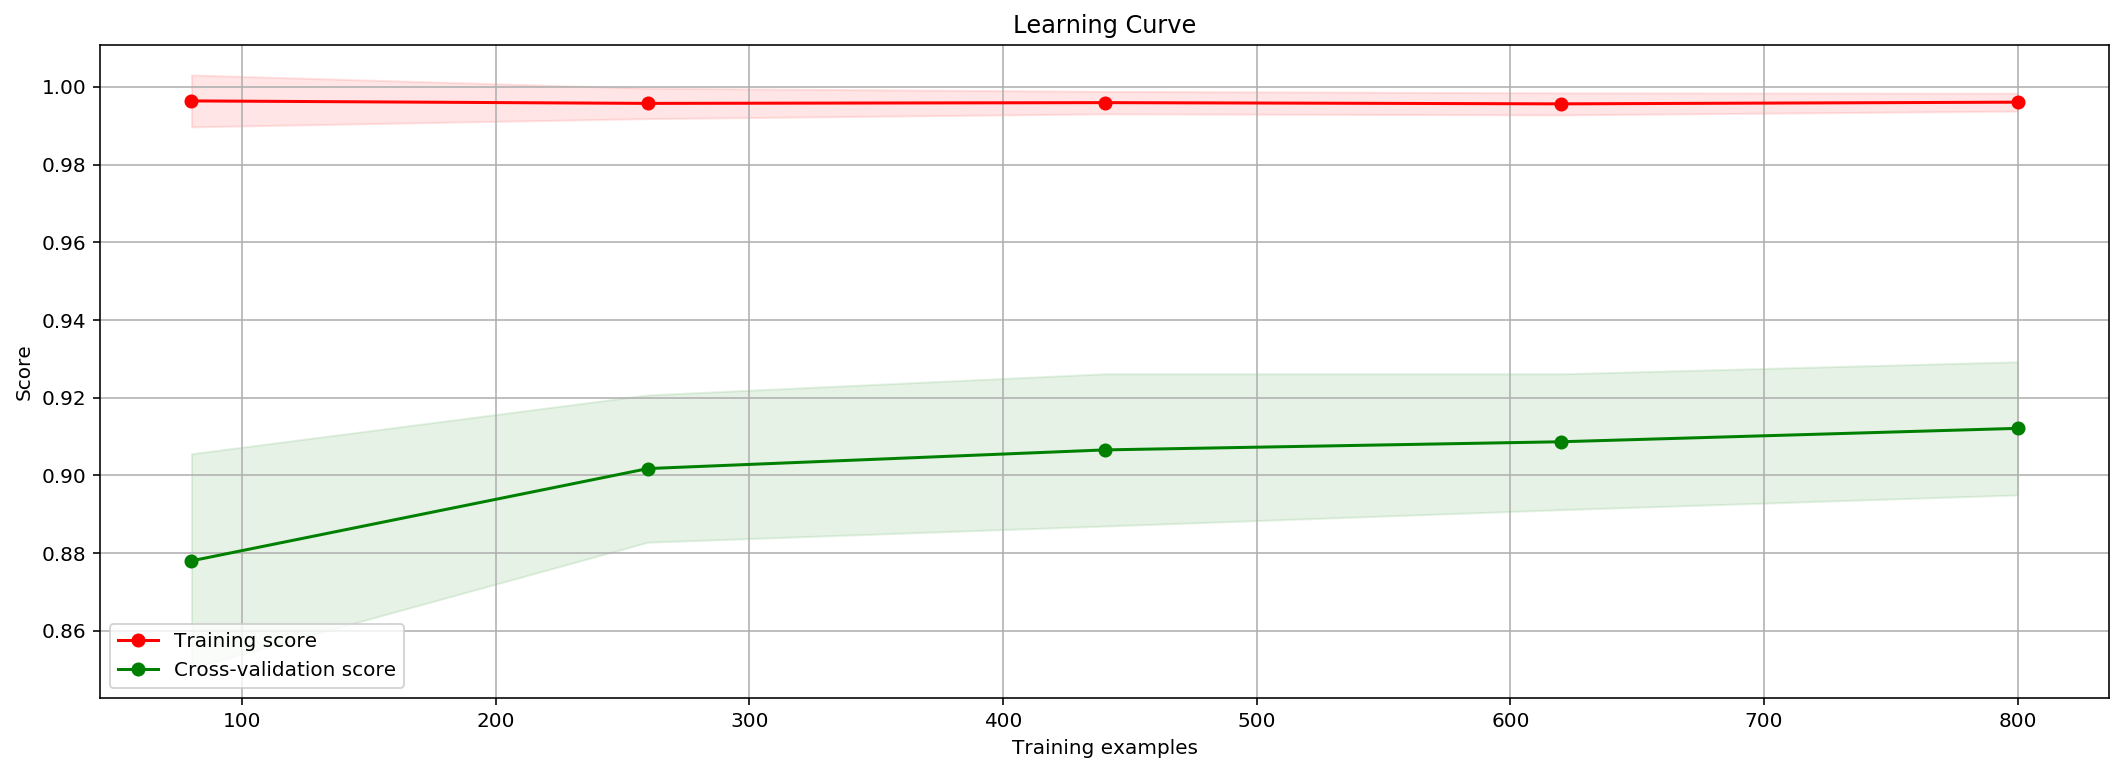

In [24]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(pip, cv=cv,
                                     X=dataset[['numeric', 'with_missing', 'text']],
                                     y=pd.get_dummies(dataset['label']))
plt.savefig('snapshot/learning_curve_plot',bbox_inches='tight',dpi=100);

[0.919675  0.9359625 0.947075  0.9578625 0.971225  0.9808    0.987475
 0.9915125 0.9938875 0.99495   0.9952    0.9955875] [0.01026313 0.00549959 0.00600578 0.00524492 0.00494653 0.00400983
 0.00330709 0.00298588 0.00265103 0.00247437 0.00246044 0.00200355]


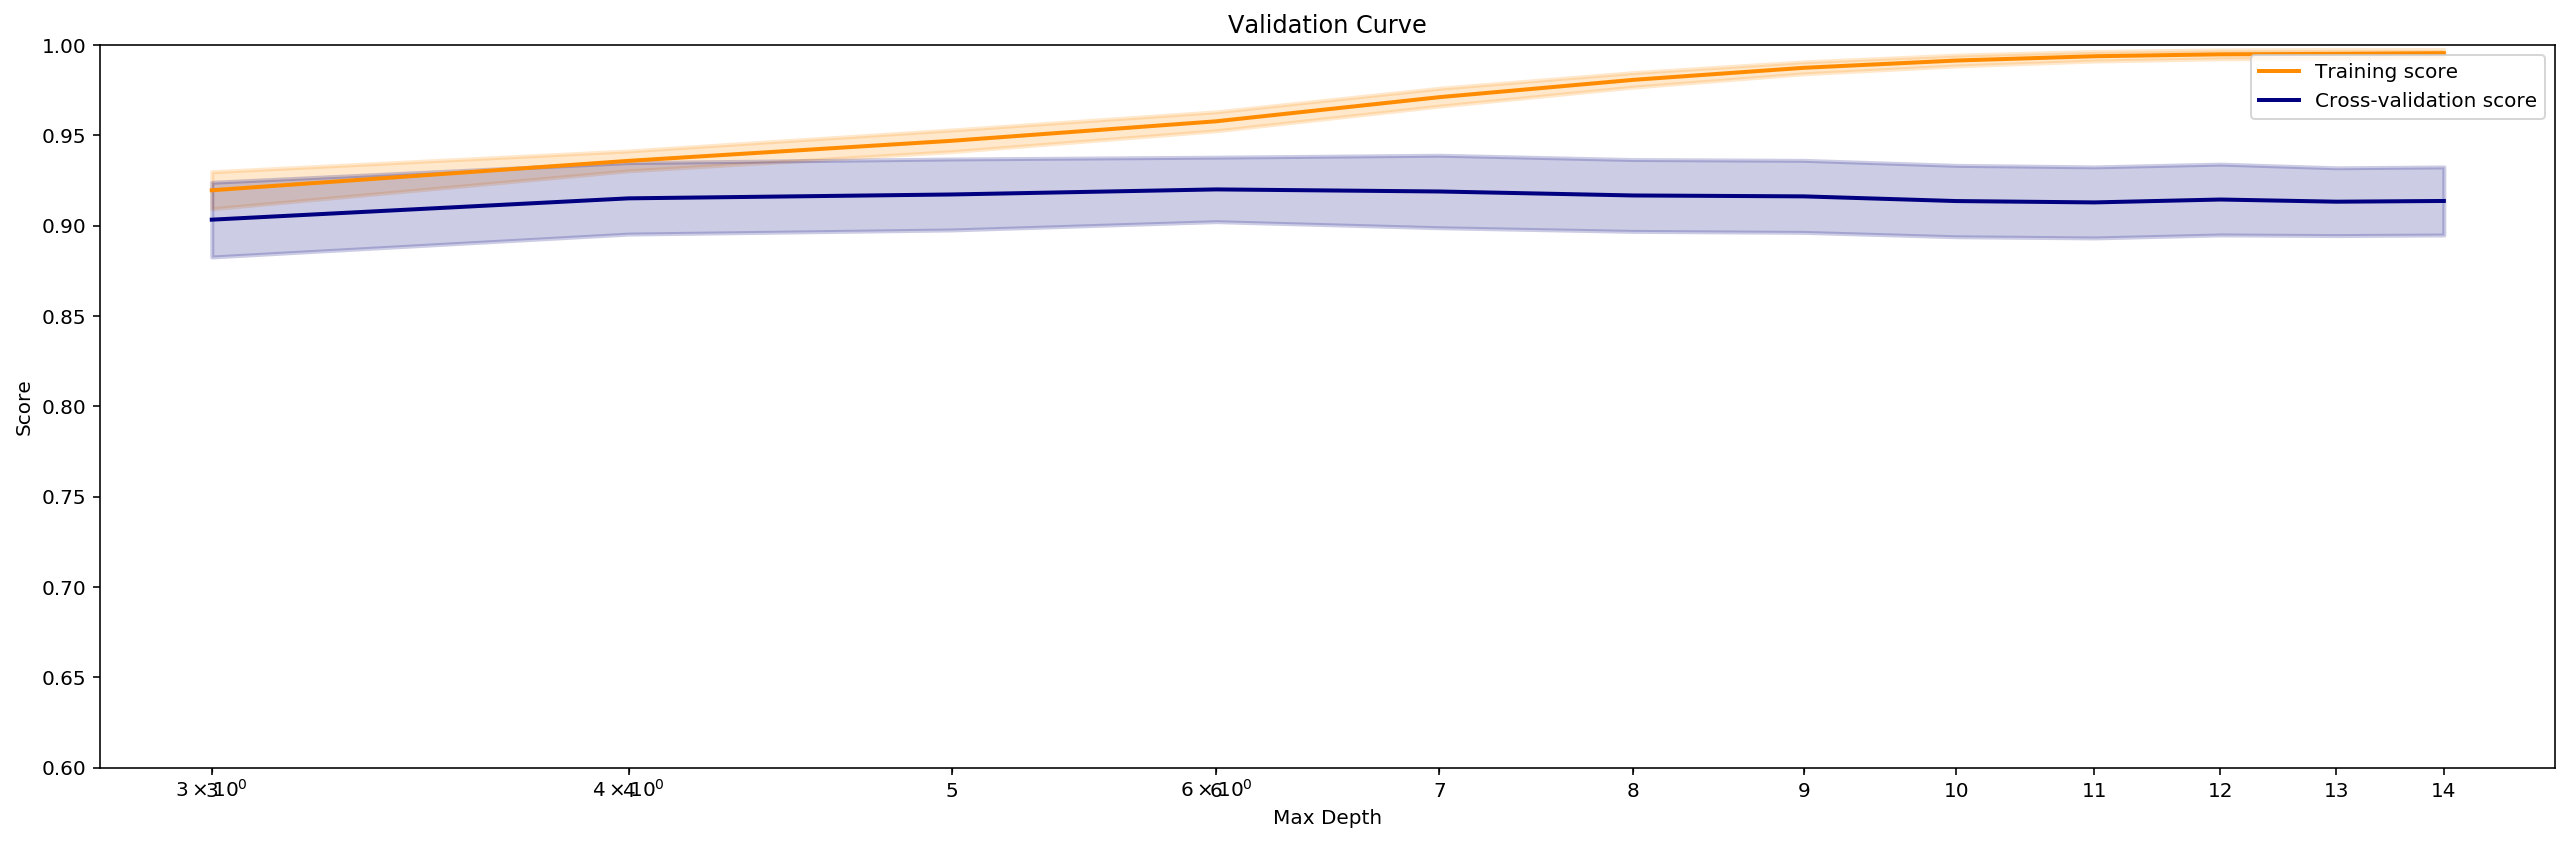

In [25]:
param_range = np.linspace(3,14,12,dtype=int)
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(
    pip, dataset[['numeric', 'with_missing', 'text']], pd.get_dummies(dataset['label']),
    param_name="clf__max_depth", param_range=param_range,
    cv=cv, scoring="accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(train_scores_mean, train_scores_std)

plt.title("Validation Curve")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.ylim(.6, 1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.xticks(param_range,param_range)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('snapshot/validation_curve',bbox_inches='tight',dpi=100);

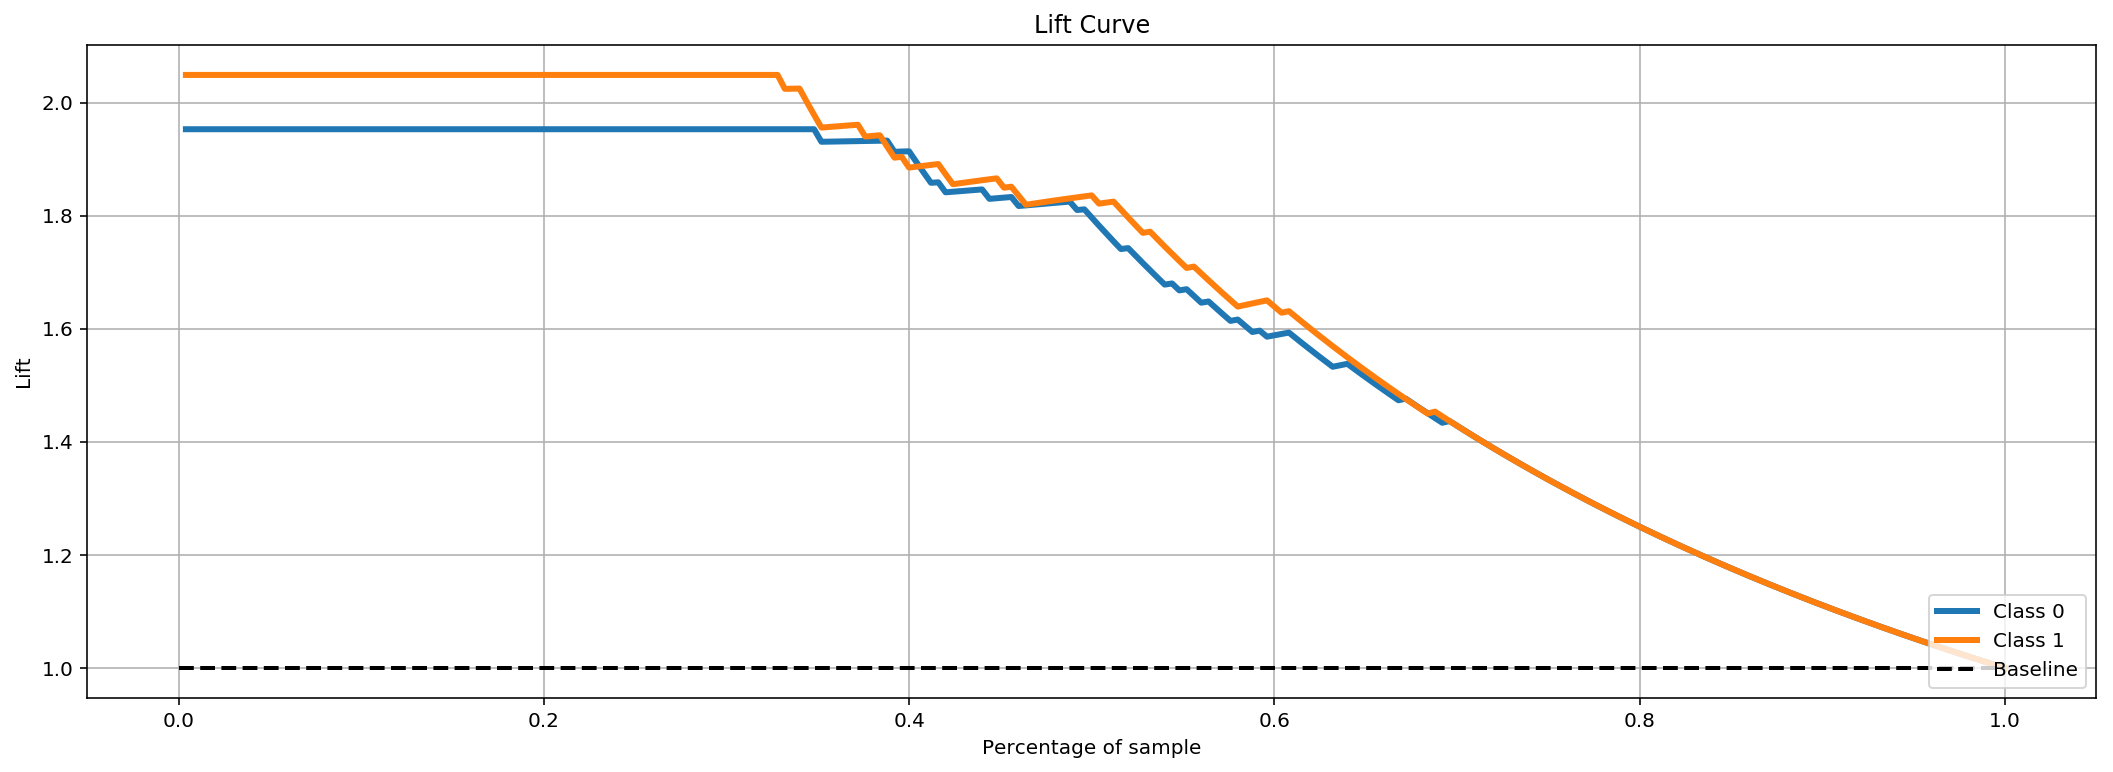

In [26]:
skplt.metrics.plot_lift_curve(y_true=y_test.iloc[:,0].values, y_probas=pip.predict_proba(X_test)[0])
plt.savefig('snapshot/lift_curve',bbox_inches='tight',dpi=100);

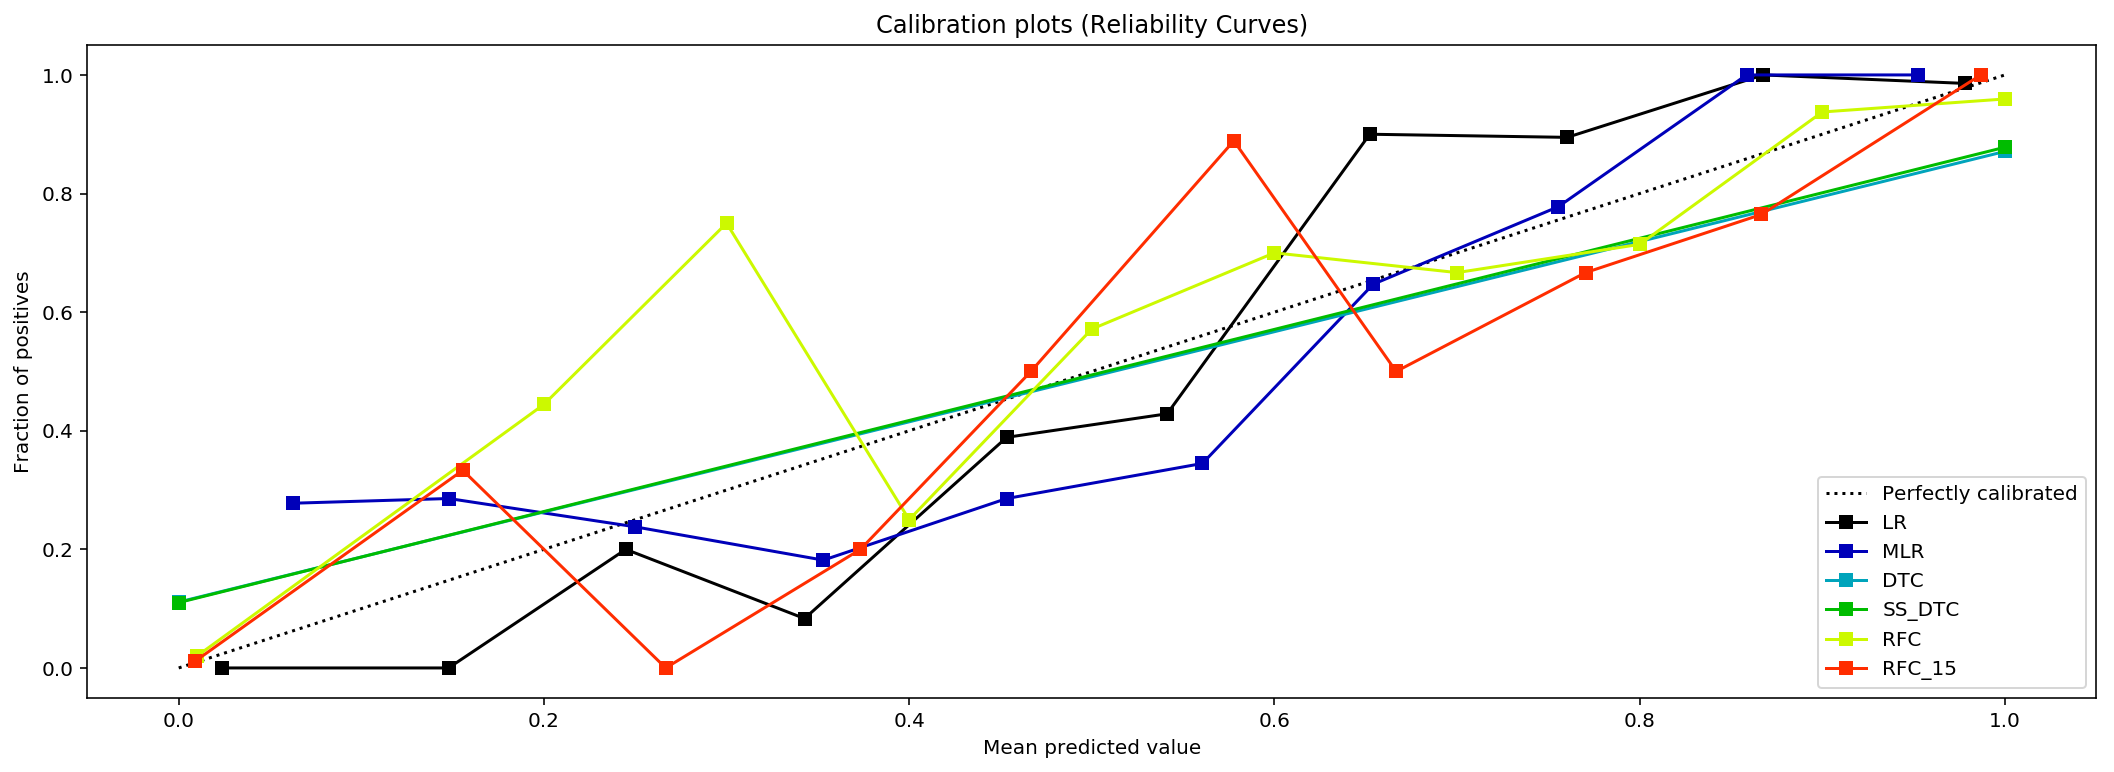

In [27]:
probas_list = [pred_prob_LR,pred_prob_M_LR,pred_prob_DT,pred_prob_SS_DT,
               pred_prob_RFC,pred_prob_RFC_15]
clf_names= ["LR","MLR","DTC","SS_DTC","RFC","RFC_15"]

import scikitplot as skplt
skplt.metrics.plot_calibration_curve(y_test.iloc[:,0],
                                     probas_list=probas_list,
                                     clf_names=clf_names,
                                     n_bins=10)
plt.savefig('snapshot/calibration_curve',bbox_inches='tight',dpi=100);